In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Reshape, Conv1DTranspose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks

Mounted at /content/drive/


# Initial cleaning

In [ ]:
def clean_df(df):
    segment_indices_code_12 = df[df['Code'] == -12].index.to_numpy()
    segment_indices_to_drop = np.concatenate(([0], segment_indices_code_12))
    df = df.drop(segment_indices_to_drop).reset_index(drop=True)

    # Remove identical rows
    df = df.loc[(df.shift() != df).any(axis=1)]
    df['Time_Diff'] = df['Epoch'].diff() > 1800
    df = remove_outliers(df)
    df = get_step_id(df)
    df = sort_df(df)

    df['Session'] = np.nan
    df['Slot'] = np.nan
    sorted_df_model = label_slot_session(df)

    return sorted_df_model


def label_slot_session(df):
    session = 0
    slots = 0
    slotEpoch = prevEpoch = df.iloc[0]['Epoch']
    for idx, row in df.iterrows():
        if row['Epoch'] - prevEpoch > 20 and row['Step'] == 0:
            session += 1
            prevEpoch = row['Epoch']
            if row['Epoch'] - slotEpoch > 30 * 60:
                slots += 1
                session = 0
                slotEpoch = row['Epoch']

        df.at[idx, 'Slot'] = slots
        df.at[idx, 'Session'] = session

    return df


def sort_df(df):
    sorted_df_model = df.sort_values(by=['Epoch', 'Time'])
    return sorted_df_model


def get_step_id(df):
    df['Sensor_Step'] = df['Sensor'] * 10 + df['Step']
    return df


def epoch_to_date(epoch_time):
    date_time = datetime.datetime.utcfromtimestamp(epoch_time)
    formatted_date = date_time.strftime('%Y-%m-%d %H:%M:%S')
    return formatted_date


def remove_outliers(df):
    cleaned_segments = []
    c = 2

    # Indices of first measurement of new session
    # Defines segment start and end points
    segment_indices_time_diff = df[df['Time_Diff'] == True].index.to_numpy()
    segment_indices = np.concatenate(([0], segment_indices_time_diff, [len(df)]))

    for i in range(len(segment_indices) - 1):
        segment = df.loc[segment_indices[i]:segment_indices[i + 1] - 1]
        if not segment['Gas'].isnull().all():
            segment_cleaned = segment.copy()

            # Calculate the IQR
            segment_cleaned = segment.copy()
            Q1 = segment['Gas'].quantile(0.25)
            Q3 = segment['Gas'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = 0
            upper_bound = Q3 + c * IQR

            # Define outlier rows and replace Gas value with NaN
            outliers = (segment['Gas'] <= lower_bound) | (segment['Gas'] > upper_bound)
            segment_cleaned.loc[outliers, 'Gas'] = np.nan

            # If first row or non-last row of segment is an outlier, takes value of following row
            segment_cleaned['Gas'].fillna(method='bfill', inplace=True)

            # If last row of segment is an outlier, takes value of previous row
            segment_cleaned['Gas'].fillna(method='ffill', inplace=True)

            cleaned_segments.append(segment_cleaned)

    df_cleaned = pd.concat(cleaned_segments, ignore_index=False)
    return df_cleaned


def standardize_df(df):
    col_names = ['Sensor', 'ID', 'Time', 'Epoch', 'Temp', 'Pressure', 'Humid', 'Gas', 'Step', 'Model', 'Lab', 'Code']
    df = df.iloc[:, :12]
    df.columns = col_names
    return df

def get_input_set_df_test(df):
    # Extract and sort relevant rows
    input_data_list = []
    sub_list = []
    counter_dict = {}
    current_session = 0

    for index, row in tqdm(df.iterrows(), total=len(df)):
        if (index > 0 and row['Session'] != current_session) or (index == len(df)-1): # if all virtual sensors finished measuring
            current_session = row['Session']
            if len(counter_dict) != 80:
                sub_list = fill_missing_sensor_steps_test(df.iloc[index-1], counter_dict, sub_list, input_data_list)

            input_data_list.extend(sorted(sub_list, key=lambda x: x[-1]))
            counter_dict, sub_list = {}, []

        vsensor = row['Sensor_Step']
        if (vsensor not in counter_dict) and (index != len(df) - 1):
            counter_dict[vsensor] = 1
            sub_list.append([row['Gas'], row['Temp'], row['Humid'], row['Pressure'], row['Slot'], row['Session'], row['Sensor_Step']])

    # this adds more preprocessing time
    input_data_list = remove_remaining_nans(input_data_list)

    input_data_df_all = list_to_df(input_data_list)
    return input_data_df_all


def fill_missing_sensor_steps_2(sub_data, data):
    df = pd.DataFrame(data, columns=['Gas', 'Temp', 'Humid', 'Pressure', 'Slot', 'Session', 'Sensor_Step'])
    for i, row in enumerate(sub_data):
        if np.nan in row:
            slot, sess, vsensor = row[-3], row[-2], row[-1]
            # print(f'\nStill missing:\nSlot: {slot}, Session: {sess}, Sensor_Step: {vsensor}')

            rows_prev_sess = df[(df['Slot'] == slot) & (df['Session'] == sess - 1) & (df['Sensor_Step'] == vsensor)]
            rows_forward_sess = df[(df['Slot'] == slot) & (df['Session'] == sess + 1) & (df['Sensor_Step'] == vsensor)]

            if not rows_prev_sess.empty:
                prev_vals = rows_prev_sess[['Gas', 'Temp', 'Humid', 'Pressure']].iloc[0] if not rows_prev_sess.iloc[0].isnull().any() else None
            else:
                prev_vals = None

            if not rows_forward_sess.empty:
                forward_vals = rows_forward_sess[['Gas', 'Temp', 'Humid', 'Pressure']].iloc[0] if not rows_forward_sess.iloc[0].isnull().any() else None
            else:
                forward_vals = None

            if prev_vals is None and forward_vals is not None:
                prev_vals = forward_vals
                # print('Future value exists')
            elif prev_vals is not None and forward_vals is None:
                forward_vals = prev_vals
                # print('Previous value exists')

            average_vals = (prev_vals + forward_vals) / 2 if prev_vals is not None and forward_vals is not None else None

            if average_vals is not None:
                sub_data[i] = [*average_vals, slot, sess, vsensor]
                # print('Average value exists')
            else:
                # print('Removed node')
                return []

    return sub_data


def fill_missing_sensor_steps_test(row, counter, sub_data, data):
    total_missing = 80 - len(counter)
    sess = row['Session']
    if total_missing < 20:
        for i in range(80):
            if i not in counter:
                if sess == 0:  # if its the first session in a slot
                    return []
                elif sess > 20:  # if its the 21+ session of the slot, take value of previous session
                    vals_prev_sess = data[-80 + i][:4]
                    sub_data.append([*vals_prev_sess, row['Slot'], row['Session'], i])
                else:  # between 0 and 20, for now just taking previous, make NaN
                    sub_data.append([np.nan, np.nan, np.nan, np.nan, row['Slot'], row['Session'], i])
                    # print(f'Filled with NaN:\nSlot: {row["Slot"]}, Session: {row["Session"]}, Sensor_Step: {i}')
        return sub_data
    return []

def remove_remaining_nans(data):
    data_copy = []
    for i in tqdm(range(len(data) // 80), total = len(data) // 80):
        sub_list = data[i * 80 : (i+1) * 80][:]
        sub_list = fill_missing_sensor_steps_2(sub_list, data)
        if sub_list:
            data_copy.extend(sub_list)

    return data_copy


def get_window_set(df, selected_date, days_before, window_size):
    target_date = pd.to_datetime(selected_date)
    start_date = target_date - pd.Timedelta(days=days_before)
    end_date = start_date + pd.Timedelta(days=window_size)
    window_set = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
    return window_set.reset_index(drop=True)

def remove_duplicates(df):
    df = df.loc[(df.shift() != df).any(axis=1)]
    return df

def list_to_df(data):
    data_df = pd.DataFrame(data, columns=['Gas', 'Temp', 'Humid', 'Pressure', 'Slot', 'Session', 'Sensor_Step'])
    # data_df = pd.DataFrame(data, columns=['Gas', 'Temp', 'Humid', 'Pressure', 'Sensor_Step']).drop(columns=['Sensor_Step'])
    return data_df

# Preprocessing -

In [ ]:
# Loading the data
file_name = 'E05A1B0CEE60_18022024T000000_01052024T000000_Home_#6_6_25.csv'
df = pd.read_csv(f'/content/drive/MyDrive/YieldX/csv_files/{file_name}')
df = standardize_df(df)
df['Datetime'] = df['Epoch'].apply(epoch_to_date)
df = df.sort_values(by=['Sensor', 'Step', 'Epoch'])

In [ ]:
df.shape

(1355992, 13)

In [ ]:
df.head()

,Sensor,ID,Time,Epoch,Temp,Pressure,Humid,Gas,Step,Model,Lab,Code,Datetime
0,0,1172147024,142400785,1708239604,29.823095,1018.900757,44.369495,109942.023438,0,1,1,0,2024-02-18 07:00:04
1,0,1172147024,142428217,1708239632,34.187061,1018.884338,41.752678,64875.824219,0,1,83,0,2024-02-18 07:00:32
2,0,1172147024,142455120,1708239658,35.048855,1018.884888,39.935204,122752.335938,0,1,163,0,2024-02-18 07:00:58
3,0,1172147024,142481972,1708239685,35.745312,1018.941711,38.590370,165321.281250,0,1,243,0,2024-02-18 07:01:25
4,0,1172147024,142508850,1708239712,36.349083,1018.959595,37.503983,202531.640625,0,1,322,0,2024-02-18 07:01:52


In [ ]:
df.tail()

,Sensor,ID,Time,Epoch,Temp,Pressure,Humid,Gas,Step,Model,Lab,Code,Datetime
1355987,7,1172121174,1425328384,1716355680,43.294537,1003.537720,28.552721,659368.9375,9,0,614618,0,2024-05-22 05:28:00
1355988,7,1172121174,1425355435,1716355707,43.337456,1003.542175,28.494848,654940.8125,9,0,614694,0,2024-05-22 05:28:27
1355989,7,1172121174,1425382446,1716355734,43.355125,1003.532104,28.468378,661285.1250,9,0,614769,0,2024-05-22 05:28:54
1355990,7,1172121174,1425409429,1716355761,43.403099,1003.522705,28.500826,656199.9375,9,0,614845,0,2024-05-22 05:29:21
1355991,7,1172121174,1425436503,1716355788,43.448540,1003.522095,28.280434,652437.0625,9,0,614920,0,2024-05-22 05:29:48


In [ ]:
# check there are no nans in the dataframe
assert df.isna().any().any() == False

In [ ]:
df = clean_df(df)
assert df.isna().any().any() == False

### Selecting window with dataframe - Calculate average for middle sessions

### Functions

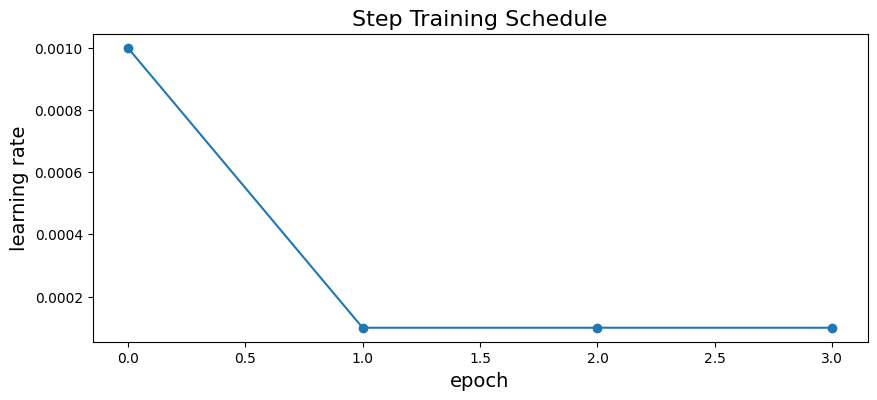

In [ ]:
def get_window_set(df, selected_date, days_before, window_size):
  target_date = pd.to_datetime(selected_date)
  start_date = target_date - pd.Timedelta(days=days_before)
  end_date = start_date + pd.Timedelta(days=window_size)
  window_set = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
  return window_set.reset_index(drop=True)

def remove_duplicates(df):
  df = df.loc[(df.shift() != df).any(axis=1)]
  return df

def epoch_to_date(epoch_time):
    date_time = datetime.datetime.utcfromtimestamp(epoch_time)
    formatted_date = date_time.strftime('%Y-%m-%d %H:%M:%S')
    return formatted_date

def fill_missing_sensor_steps(row, counter, sub_data, data):
      total_missing = 80 - len(counter)
      sess = row['Session']
      if total_missing < 20:
          for i in range(80):
              if i not in counter:
                  if sess == 0: # if its the first session in a slot
                      return []
                  else:
                      vals_prev_sess = data[-80 + i][:4]
                      sub_data.append([*vals_prev_sess, row['Slot'], row['Session'], i])
          return sub_data
      return []

def list_to_df(data):
    data_df = pd.DataFrame(data, columns=['Gas', 'Temp', 'Humid', 'Pressure', 'Slot', 'Session', 'Sensor_Step'])
    # data_df = pd.DataFrame(data, columns=['Gas', 'Temp', 'Humid', 'Pressure', 'Sensor_Step']).drop(columns=['Sensor_Step'])
    return data_df



def get_input_set_df(df):
    # Extract and sort relevant rows
    input_data_list = []
    sub_list = []
    counter_dict = {}
    current_session = 0

    for index, row in tqdm(df.iterrows(), total=len(df)):
        if (index > 0 and row['Session'] != current_session) or (index == len(df)-1): # if all virtual sensors finished measuring
            current_session = row['Session']
            if len(counter_dict) != 80:
                sub_list = fill_missing_sensor_steps(df.iloc[index-1], counter_dict, sub_list, input_data_list)

            input_data_list.extend(sorted(sub_list, key=lambda x: x[-1]))
            counter_dict, sub_list = {}, []
        vsensor = row['Sensor_Step']
        if (vsensor not in counter_dict) and (index != len(df) - 1):
            counter_dict[vsensor] = 1
            sub_list.append([row['Gas'], row['Temp'], row['Humid'], row['Pressure'], row['Slot'], row['Session'], row['Sensor_Step']])

    input_data_df_all = list_to_df(input_data_list)
    return input_data_df_all


def remove_remaining_nans(data):
    data_copy = []
    for i in tqdm(range(len(data) // 80), total = len(data) // 80):
        sub_list = data[i * 80 : (i+1) * 80][:]
        sub_list = fill_missing_sensor_steps_2(sub_list, data)
        if sub_list:
            data_copy.extend(sub_list)

    return data_copy

def train_and_val_sets(df, n_splits):
  unique_slots = df['Slot'].unique()
  n_splits = 3
  num_slots_per_split = len(unique_slots) // n_splits
  train_data_all_df, val_data_all_df = {}, {}

  for i in range(n_splits):
      slots_indexes = unique_slots[i*num_slots_per_split : (i+1)*num_slots_per_split]
      train_slots, val_slots = train_test_split(slots_indexes, test_size=0.2, shuffle=False)
      train_data_all_df[i] = df[df['Slot'].isin(train_slots)].drop(['Slot', 'Session', 'Sensor_Step'], axis=1, inplace=False)
      val_data_all_df[i] = df[df['Slot'].isin(val_slots)].drop(['Slot', 'Session', 'Sensor_Step'], axis=1, inplace=False)

  return train_data_all_df, val_data_all_df

def scale_data_together(train, val, n_splits):
  train_scaled_reshaped, val_scaled_reshaped = {}, {}

  for i in range(n_splits):
      scaler = StandardScaler()
      train_scaled = scaler.fit_transform(train[i])
      val_scaled = scaler.transform(val[i])

      train_scaled_reshaped[i] = train_scaled.reshape(-1, 80, 4)
      val_scaled_reshaped[i] = val_scaled.reshape(-1, 80, 4)

      print(f'Fold {i}:')
      print(f'train_all_scaled_all_sensors.shape:', train_scaled_reshaped[i].shape)
      print(f'val_all_scaled_all_sensors.shape:', val_scaled_reshaped[i].shape)
      print('\n')
  return train_scaled_reshaped, val_scaled_reshaped

def scale_data_separate_sensors(train, val, n_splits):
    train_all_scaled_each_sensor, val_all_scaled_each_sensor = {}, {}

    for i in range(n_splits):
        train_np = np.array(train[i]).reshape(-1, 80, train[i].shape[1])
        val_np = np.array(val[i]).reshape(-1, 80, train[i].shape[1])

        for sensor in range(80):
            scaler = StandardScaler()
            sensor_data_train, sensor_data_val = train_np[:, sensor, :], val_np[:, sensor, :]
            scaled_sensor_data_train = scaler.fit_transform(sensor_data_train)
            scaled_sensor_data_val = scaler.transform(sensor_data_val)

            # Replace the original data with the scaled data
            train_np[:, sensor, :] = scaled_sensor_data_train
            val_np[:, sensor, :] = scaled_sensor_data_val
        train_all_scaled_each_sensor[i], val_all_scaled_each_sensor[i] = train_np, val_np
        print(f'Fold {i}:')
        print(f'train_scaled_separately.shape:', train_all_scaled_each_sensor[i].shape)
        print(f'val_scaled_separately.shape:', val_all_scaled_each_sensor[i].shape)
        print('\n')
    return train_all_scaled_each_sensor, val_all_scaled_each_sensor

def custom_loss(y_true, y_pred):
    gas_true = y_true[:, :, 0]
    gas_pred = y_pred[:, :, 0]
    return tf.reduce_mean(tf.square(gas_true - gas_pred))

def build_model(model_name):
    input_shape = (80, 4)
    hidden1_dim = 64
    hidden2_dim = 32

    encoder_input = tf.keras.Input(shape=input_shape)
    x = layers.Conv1D(hidden1_dim, kernel_size=3, activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)

    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoder_output = layers.Conv1D(4, kernel_size=3, activation='linear', padding='same')(x)


    autoencoder = models.Model(encoder_input, decoder_output)

    autoencoder.compile(optimizer='adam', loss=custom_loss)
    return autoencoder

def append_history(history):
    for i in range(n_splits):
      if len(history[i].history['val_loss']) < 100:
          last_val = history[i].history['val_loss'][-1]
          while len(history[i].history['val_loss']) < 100:
              history[i].history['val_loss'].append(last_val)
    return history

def lrfn(epoch):
    if epoch < 1:
      lr = 1e-3
    elif 1 <= epoch < 20:
      lr = 1e-4
    else:
      lr = 1e-5
    return lr

rng = [i for i in range(4)]
# y = [lrfn_2(x) for x in rng]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-');
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### Preprocessing data

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
selected_date = '2024-04-17'
days_before = 23
window_size = 23

window_data = get_window_set(df, selected_date, days_before, window_size)
input_all = get_input_set_df(window_data)
print(f'input_all.shape: {input_all.shape}')

100%|██████████| 302623/302623 [00:31<00:00, 9568.74it/s] 


input_all.shape: (301440, 7)


In [ ]:
assert window_data.isna().any().any() == False
assert input_all.isna().any().any() == False

In [ ]:
input_all.head()

,Gas,Temp,Humid,Pressure,Slot,Session,Sensor_Step
0,1.271418e+05,22.370777,55.290024,1007.518188,112.0,0.0,0
1,1.737802e+06,25.051037,55.697094,1007.514343,112.0,0.0,1
2,1.971126e+06,25.356640,54.695202,1007.489929,112.0,0.0,2
3,2.652850e+06,25.737396,51.734509,1007.526062,112.0,0.0,3
4,2.708278e+05,26.316046,51.526276,1007.539124,112.0,0.0,4


In [ ]:
input_all.tail()

,Gas,Temp,Humid,Pressure,Slot,Session,Sensor_Step
301435,5.384160e+06,48.210106,30.117516,1003.633789,169.0,65.0,75
301436,1.062172e+07,47.889462,30.464783,1003.657532,169.0,65.0,76
301437,2.726690e+07,47.687481,30.508076,1003.648315,169.0,65.0,77
301438,6.330452e+07,46.821499,31.296108,1003.622009,169.0,65.0,78
301439,3.342037e+05,49.326057,30.577938,1003.624512,169.0,65.0,79


### Splitting to train and validation sets using dataframes

In [ ]:
train, val = train_and_val_sets(input_all, 3)

We can see that for Fold 0, the train data ends with Slot 36 and the validation data begins with Slot 37.

### Scaling by according to each virtual sensor

In [ ]:
# def reshape_dataframe(df, shape_1=80, shape_2=None):
#     # Reshape the DataFrame into (num_rows, 80, 4)
#     num_rows = len(df) // shape_1
#     if shape_2 is not None:
#         reshaped_data = df.iloc[:num_rows * shape_1].values.reshape(num_rows, shape_1, shape_2)
#     else:
#         reshaped_data = df.iloc[:num_rows * shape_1].values.reshape(num_rows, shape_1)
#     return reshaped_data

In [ ]:
# def scale_data_separate_sensors_OG(train, val, n_splits):
#     train_all_scaled_each_sensor, val_all_scaled_each_sensor = {}, {}


#     for i in range(n_splits):
#         train_np = np.array(train[i]).reshape(-1, 80, 4)
#         val_np = np.array(val[i]).reshape(-1, 80, 4)

#         scaler = StandardScaler()
#         train_all_flattened = train_np.reshape(-1, train_np.shape[-1])
#         val_all_flattened = val_np.reshape(-1, val_np.shape[-1])

#         # fit and transform
#         scaler.fit(train_all_flattened)
#         train_all_standardized_flattened = scaler.transform(train_all_flattened)
#         val_all_standardized_flattened = scaler.transform(val_all_flattened)

#         train_all_scaled_each_sensor[i] = train_all_standardized_flattened.reshape(train_np.shape)
#         val_all_scaled_each_sensor[i] = val_all_standardized_flattened.reshape(val_np.shape)

#         print(f'Fold {i}:')
#         print(f'train_scaled_separately.shape:', train_all_scaled_each_sensor[i].shape)
#         print(f'val_scaled_separately.shape:', val_all_scaled_each_sensor[i].shape)
#         print('\n')
#     return train_all_scaled_each_sensor, val_all_scaled_each_sensor

In [ ]:
train_all_scaled_each_sensor, val_all_scaled_each_sensor = scale_data_separate_sensors(train, val, 3)

Fold 0:
train_scaled_separately.shape: (972, 80, 4)
val_scaled_separately.shape: (262, 80, 4)


Fold 1:
train_scaled_separately.shape: (979, 80, 4)
val_scaled_separately.shape: (261, 80, 4)


Fold 2:
train_scaled_separately.shape: (969, 80, 4)
val_scaled_separately.shape: (260, 80, 4)




### Scaling across different virtual sensors

In [ ]:
# def reshape_dataframe_2(array):
#     # Reshape the DataFrame into (num_rows, 80, 4)
#     num_rows = len(array) // 80
#     reshaped_data = array[:num_rows * 80]
#     return reshaped_data

In [ ]:
train_all_scaled_all_sensors, val_all_scaled_all_sensors = scale_data_together(train, val, 3)

Fold 0:
train_all_scaled_all_sensors.shape: (972, 80, 4)
val_all_scaled_all_sensors.shape: (262, 80, 4)


Fold 1:
train_all_scaled_all_sensors.shape: (979, 80, 4)
val_all_scaled_all_sensors.shape: (261, 80, 4)


Fold 2:
train_all_scaled_all_sensors.shape: (969, 80, 4)
val_all_scaled_all_sensors.shape: (260, 80, 4)




# Autoencoder Models

### Storing different models

In [ ]:
model_dictionary = {}

## Model 1 -Each sensor scaled separately

In [ ]:
history = {}
n_splits = 3
model_name_original = 'model_each_sensor_scaled_separately'
for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model(model_name=model_name_original)
    history[i] = autoencoder.fit(train_all_scaled_each_sensor[i], train_all_scaled_each_sensor[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_all_scaled_each_sensor[i], val_all_scaled_each_sensor[i]),
                              callbacks=[LR, early_stopping])
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 2s 23ms/step - loss: 0.2124 - val_loss: 0.2271 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0413 - val_loss: 0.1906 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0384 - val_loss: 0.1682 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0368 - val_loss: 0.1697 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0354 - val_loss: 0.1658 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

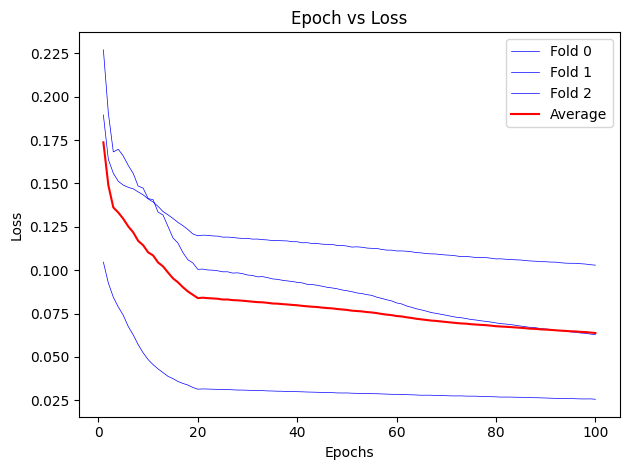

In [ ]:
history = append_history(history)
avg_val_loss_separate = np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)

for i in range(n_splits):
    loss = history[i].history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Fold {i}', color='blue', linewidth=0.5)

plt.plot(epochs, avg_val_loss_separate, label='Average', color='red')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for i in range(n_splits):
  model_name = model_name_original + f'_fold_{i}'
  model_dictionary[model_name] = history[i].history['val_loss']

## Model 2 - All sensors scaled together

In [ ]:
history = {}
model_name_original = 'model_each_sensor_scaled_together'
for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model(model_name=model_name)
    history[i] = autoencoder.fit(train_all_scaled_all_sensors[i], train_all_scaled_all_sensors[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_all_scaled_all_sensors[i], val_all_scaled_all_sensors[i]),
                              callbacks=[LR, early_stopping])
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.5447 - val_loss: 0.5236 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.2797 - val_loss: 0.4756 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.2573 - val_loss: 0.4366 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.2372 - val_loss: 0.4020 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.2179 - val_loss: 0.3677 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

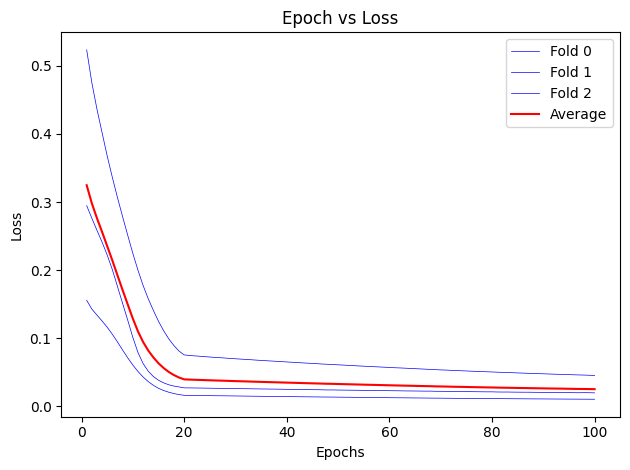

In [ ]:
history = append_history(history)
avg_val_loss_together = np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)

for i in range(n_splits):
    loss = history[i].history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, label=f'Fold {i}', color='blue', linewidth=0.5)

plt.plot(epochs, avg_val_loss_together, label='Average', color='red')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for i in range(n_splits):
  model_name = model_name_original + f'_fold_{i}'
  model_dictionary[model_name] = history[i].history['val_loss']

# Comparison of Scaling Techniques

In [ ]:
model_dictionary.keys()

dict_keys(['model_each_sensor_scaled_separately_fold_0', 'model_each_sensor_scaled_separately_fold_1', 'model_each_sensor_scaled_separately_fold_2', 'model_each_sensor_scaled_together_fold_0', 'model_each_sensor_scaled_together_fold_1', 'model_each_sensor_scaled_together_fold_2'])

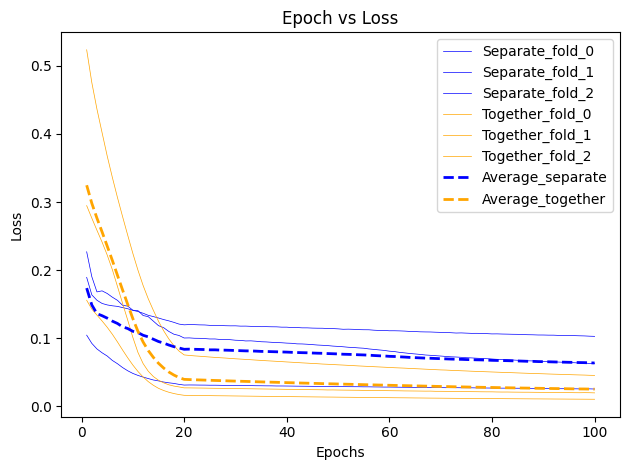

In [ ]:
for model_key in model_dictionary.keys():
    i = model_key[-1]
    loss = model_dictionary[model_key]
    epochs = range(1, len(loss) + 1)
    if 'separately' in model_key:
      plt.plot(epochs, loss, label=f'Separate_fold_{i}', color='blue', linewidth=0.5)
    else:
      plt.plot(epochs, loss, label=f'Together_fold_{i}', color='orange', linewidth=0.5)

plt.plot(epochs, avg_val_loss_separate, label='Average_separate', color='blue', linewidth=2, linestyle='dashed')
plt.plot(epochs, avg_val_loss_together, label='Average_together', color='orange', linewidth=2, linestyle='dashed')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.ylim(0, 0.02)
plt.tight_layout()
plt.show()

We can see that scaling the data together produces a more stable/consistent MSE value. HOWEVER, logic dictates that it makes much more sense to scale the data according to sensor. This becomes apparent later on when we try to reconstruct the data. Although the MSE may be lower, scaling together causes a shift in the data. Therefore, we will continue with scaling the data separately.

# Preserving order of the rows - No shuffling

### Model 1 - Each sensor scaled separately

In [ ]:
history = {}
model_name_original = 'model_each_sensor_scaled_separately_ordered'
for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model(model_name=model_name_original)
    history[i] = autoencoder.fit(train_all_scaled_each_sensor[i], train_all_scaled_each_sensor[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_all_scaled_each_sensor[i], val_all_scaled_each_sensor[i]),
                              callbacks=[LR, early_stopping],
                              shuffle=False)
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 2s 23ms/step - loss: 0.6492 - val_loss: 0.9115 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.1965 - val_loss: 0.6366 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.1366 - val_loss: 0.4501 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1003 - val_loss: 0.3247 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0813 - val_loss: 0.2506 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

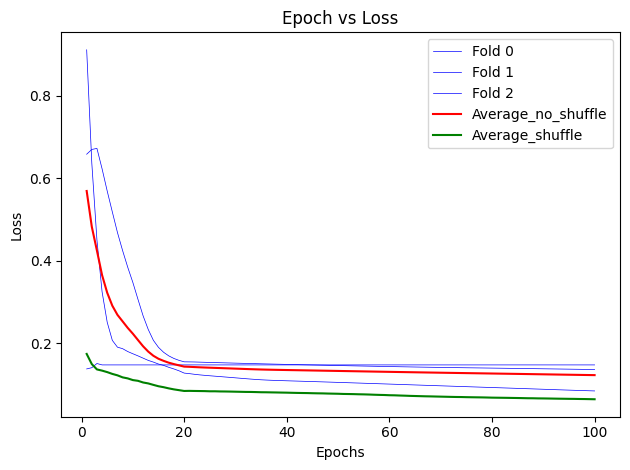

In [ ]:
history = append_history(history)
avg_val_loss_separate_no_shuffle = np.mean([history[i].history['val_loss'] for i in range(n_splits) if len(history[i].history['val_loss']) > 90], axis=0)

for i in range(n_splits):
    loss = history[i].history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Fold {i}', color='blue', linewidth=0.5)

plt.plot(epochs, avg_val_loss_separate_no_shuffle, label='Average_no_shuffle', color='red')
plt.plot(epochs, avg_val_loss_separate, label='Average_shuffle', color='green')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Model 2 - All sensors scaled together



In [ ]:
model_name_original = 'model_each_sensor_scaled_together_ordered'

for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model(model_name=model_name_original)
    history[i] = autoencoder.fit(train_all_scaled_all_sensors[i], train_all_scaled_all_sensors[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_all_scaled_all_sensors[i], val_all_scaled_all_sensors[i]),
                              callbacks=[LR, early_stopping],
                              shuffle=False)
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.5321 - val_loss: 0.6101 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.3637 - val_loss: 0.5582 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 0.3159 - val_loss: 0.5332 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 0.2938 - val_loss: 0.5059 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.2758 - val_loss: 0.4771 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

## Conclusions

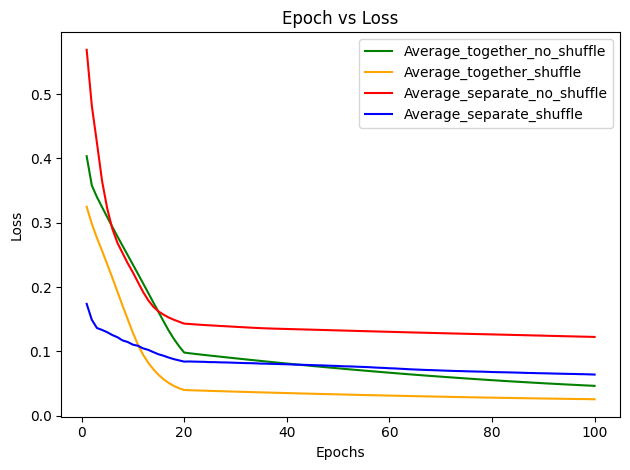

In [ ]:
history = append_history(history)
avg_val_loss_together_no_shuffle = np.mean([history[i].history['val_loss'] for i in range(n_splits) if len(history[i].history['val_loss']) > 90], axis=0)

epochs = range(1, len(loss) + 1)
plt.plot(epochs, avg_val_loss_together_no_shuffle, label='Average_together_no_shuffle', color='green')
plt.plot(epochs, avg_val_loss_together, label='Average_together_shuffle', color='orange')
plt.plot(epochs, avg_val_loss_separate_no_shuffle, label='Average_separate_no_shuffle', color='red')
plt.plot(epochs, avg_val_loss_separate, label='Average_separate_shuffle', color='blue')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

To compare the effect of shuffling the data:
compare green with orange, or red with blue. Orange (shuffled) performs better than green (non-shuffled). Blue (shuffled) performs better than red (non-shuffled). This is likely because ordered (non-shuffled) data causes the model to overfit. **Therefore, shuffling the data is the preferred method**.

To compare the effect of scaling methods, compare orange with blue (scaled together versus scaled separately). Between blue and orange (both shuffled), orange (scaled together) appears to perform better. If we compare green with red (no shuffle), then the green performed better (scaled together).  However, as explained before, later on it proves that the reconstruction is much much better when the data is scaled separately. **Therefore, scaling separately is the preferred method.**


# Replacing Missing values

We will compare two different techniques of replacing missing values. The first technique is to just replace the node with the value of the previous session (same slot/sensor_step), which we have already done. The second technique is to take the average of the previous and future sessions. We will apply this second technique now and compare.

## Replacing missing values with average value

### Functions

### Running code

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
selected_date = '2024-04-17'
days_before = 23
window_size = 23

window_data = get_window_set(df, selected_date, days_before, window_size)
input_all = get_input_set_df_test(window_data)
print(f'input_all.shape: {input_all.shape}')

100%|██████████| 3768/3768 [15:43<00:00,  3.99it/s]


input_all.shape: (300000, 7)


In [ ]:
train, val = train_and_val_sets(input_all, 3)
train_scaled, val_scaled = scale_data_separate_sensors(train, val, 3) # scaling separate

Fold 0:
train_scaled_separately.shape: (964, 80, 4)
val_scaled_separately.shape: (262, 80, 4)


Fold 1:
train_scaled_separately.shape: (979, 80, 4)
val_scaled_separately.shape: (261, 80, 4)


Fold 2:
train_scaled_separately.shape: (962, 80, 4)
val_scaled_separately.shape: (257, 80, 4)




In [ ]:
history = {}
n_splits = 3
model_name_original = 'model_missing_replaced_with_average'
for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model(model_name=model_name_original)
    history[i] = autoencoder.fit(train_scaled[i], train_scaled[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_scaled[i], val_scaled[i]),
                              callbacks=[LR, early_stopping])
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.3375 - val_loss: 0.1552 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0612 - val_loss: 0.1221 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0515 - val_loss: 0.1245 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0456 - val_loss: 0.1190 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0420 - val_loss: 0.1158 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

### Conclusion

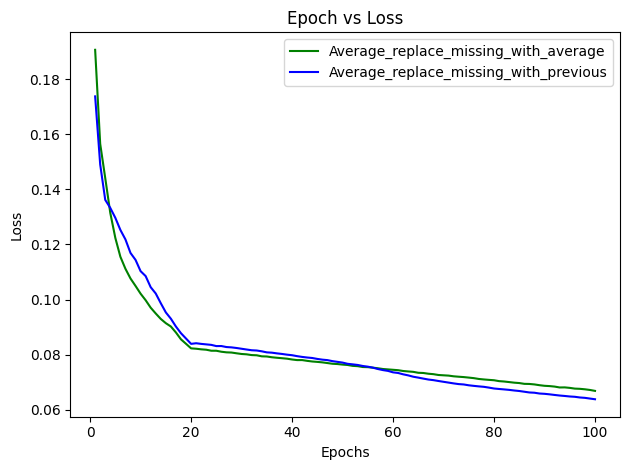

In [ ]:
history = append_history(history)
avg_val_loss_missing_with_average = np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)

epochs = range(1, len(loss) + 1)
plt.plot(epochs, avg_val_loss_missing_with_average, label='Average_replace_missing_with_average', color='green')
plt.plot(epochs, avg_val_loss_separate, label='Average_replace_missing_with_previous', color='blue')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

There is little to no difference observed, however replacing the value with the previous instead of the average seems to slightly outperform. Likely because this particular dataset is missing values mostly from later sessions (sessions 35+), after the value has already converged. We will check with a different dataset to see if we get different results.

# Adding 'Time-Slot' feature

### Functions

In [ ]:
def clean_df_with_time_slot(df):
    segment_indices_code_12 = df[df['Code'] == -12].index.to_numpy()
    segment_indices_to_drop = np.concatenate(([0], segment_indices_code_12))
    df = df.drop(segment_indices_to_drop).reset_index(drop=True)

    # Remove identical rows
    df = df.loc[(df.shift() != df).any(axis=1)]
    df['Time_Diff'] = df['Epoch'].diff() > 1800
    df = remove_outliers(df)
    df = get_step_id(df)
    df = sort_df(df)
    df = get_time_slot_label(df)

    df['Session'] = np.nan
    df['Slot'] = np.nan
    sorted_df_model = label_slot_session(df)

    return sorted_df_model

def get_time_slot_label(df):
    df['Hour'] = df['Datetime'].dt.hour

    def assign_time_slot(hour):
        if 0 <= hour < 6:
            return 0
        elif 6 <= hour < 12:
            return 1
        elif 12 <= hour < 18:
            return 2
        elif 18 <= hour < 24:
            return 3

    df['Time_Slot'] = df['Hour'].apply(assign_time_slot)
    df.drop('Hour', axis=1, inplace=True)
    return df

def label_slot_session_with_time_slot(df):
    session = 0
    slots = 0
    slotEpoch = prevEpoch = df.iloc[0]['Epoch']
    for idx, row in df.iterrows():
        if row['Epoch'] - prevEpoch > 20 and row['Step'] == 0:
            session += 1
            prevEpoch = row['Epoch']
            if row['Epoch'] - slotEpoch > 30 * 60:
                slots += 1
                session = 0
                slotEpoch = row['Epoch']

        df.at[idx, 'Slot'] = slots
        df.at[idx, 'Session'] = session

    return df

def fill_missing_sensor_steps_with_time_slot(row, counter, sub_data, data):
      total_missing = 80 - len(counter)
      sess = row['Session']
      if total_missing < 20:
          for i in range(80):
              if i not in counter:
                  if sess == 0: # if its the first session in a slot
                      return []
                  else:
                      vals_prev_sess = data[-80 + i][:4]
                      sub_data.append([*vals_prev_sess, row['Time_Slot'], row['Slot'], row['Session'], i]) #
          return sub_data
      return []

def list_to_df_with_time_slot(data):
    data_df = pd.DataFrame(data, columns=['Gas', 'Temp', 'Humid', 'Pressure', 'Time_Slot', 'Slot', 'Session', 'Sensor_Step']) #
    # data_df = pd.DataFrame(data, columns=['Gas', 'Temp', 'Humid', 'Pressure', 'Sensor_Step']).drop(columns=['Sensor_Step'])
    return data_df


def get_input_set_df_with_time_slot(df):
    # Extract and sort relevant rows
    input_data_list = []
    sub_list = []
    counter_dict = {}
    current_session = 0

    for index, row in tqdm(df.iterrows(), total=len(df)):
        if (index > 0 and row['Session'] != current_session) or (index == len(df)-1): # if all virtual sensors finished measuring
            current_session = row['Session']
            if len(counter_dict) != 80:
                sub_list = fill_missing_sensor_steps_with_time_slot(df.iloc[index-1], counter_dict, sub_list, input_data_list) #

            input_data_list.extend(sorted(sub_list, key=lambda x: x[-1]))
            counter_dict, sub_list = {}, []
        vsensor = row['Sensor_Step']
        if (vsensor not in counter_dict) and (index != len(df) - 1):
            counter_dict[vsensor] = 1
            sub_list.append([row['Gas'], row['Temp'], row['Humid'], row['Pressure'], row['Time_Slot'], row['Slot'], row['Session'], row['Sensor_Step']]) #

    input_data_df_all = list_to_df_with_time_slot(input_data_list) #
    return input_data_df_all

def build_model_with_time_slot(model_name):
    input_shape = (80, 5)
    hidden1_dim = 64
    hidden2_dim = 32

    encoder_input = tf.keras.Input(shape=input_shape)
    x = layers.Conv1D(hidden1_dim, kernel_size=3, activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)

    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoder_output = layers.Conv1D(4, kernel_size=3, activation='linear', padding='same')(x)


    autoencoder = models.Model(encoder_input, decoder_output)

    autoencoder.compile(optimizer='adam', loss=custom_loss)
    return autoencoder


def train_and_val_sets_with_time_slot(df, n_splits):
  unique_slots = df['Slot'].unique()
  n_splits = 3
  num_slots_per_split = len(unique_slots) // n_splits
  train_data_all_df, val_data_all_df = {}, {}

  for i in range(n_splits):
      slots_indexes = unique_slots[i*num_slots_per_split : (i+1)*num_slots_per_split]
      train_slots, val_slots = train_test_split(slots_indexes, test_size=0.2, shuffle=False)
      train_data_all_df[i] = df[df['Slot'].isin(train_slots)].drop(['Slot', 'Session', 'Sensor_Step'], axis=1, inplace=False)
      val_data_all_df[i] = df[df['Slot'].isin(val_slots)].drop(['Slot', 'Session', 'Sensor_Step'], axis=1, inplace=False)
  return train_data_all_df, val_data_all_df


# def scale_data_together_with_time_slot(train, val, n_splits):
#   train_scaled_reshaped, val_scaled_reshaped = {}, {}

#   for i in range(n_splits):
#       scaler = StandardScaler()
#       train_scaled = scaler.fit_transform(train[i])
#       val_scaled = scaler.transform(val[i])

#       train_scaled_reshaped[i] = train_scaled.reshape(-1, 80, 5)
#       val_scaled_reshaped[i] = val_scaled.reshape(-1, 80, 5)

#       print(f'Fold {i}:')
#       print(f'train_all_scaled_all_sensors.shape:', train_scaled_reshaped[i].shape)
#       print(f'val_all_scaled_all_sensors.shape:', val_scaled_reshaped[i].shape)
#       print('\n')
#   return train_scaled_reshaped, val_scaled_reshaped

# def scale_data_together_with_time_slot(train, val, n_splits):
#     train_scaled_reshaped, val_scaled_reshaped = {}, {}

#     for i in range(n_splits):
#         scaler = StandardScaler()

#         # Separate continuous and discrete features
#         train_continuous = train[i][:, :-1]
#         train_discrete = train[i][:, -1]
#         val_continuous = val[i][:, :-1]
#         val_discrete = val[i][:, -1]

#         # Scale only the continuous features
#         train_continuous_scaled = scaler.fit_transform(train_continuous)
#         val_continuous_scaled = scaler.transform(val_continuous)

#         # Concatenate scaled continuous features with discrete feature
#         train_scaled = np.hstack((train_continuous_scaled, train_discrete.reshape(-1, 1)))
#         val_scaled = np.hstack((val_continuous_scaled, val_discrete.reshape(-1, 1)))

#         train_scaled_reshaped[i] = train_scaled.reshape(-1, 80, 5)
#         val_scaled_reshaped[i] = val_scaled.reshape(-1, 80, 5)

#         print(f'Fold {i}:')
#         print(f'train_all_scaled_all_sensors.shape:', train_scaled_reshaped[i].shape)
#         print(f'val_all_scaled_all_sensors.shape:', val_scaled_reshaped[i].shape)
#         print('\n')

#     return train_scaled_reshaped, val_scaled_reshaped

def scale_data_together_with_time_slot(train, val, n_splits):
    train_scaled_reshaped, val_scaled_reshaped = {}, {}

    for i in range(n_splits):
        scaler = StandardScaler()

        # Separate continuous and discrete features
        train_continuous = train[i].iloc[:, :-1].values
        train_discrete = train[i].iloc[:, -1].values
        val_continuous = val[i].iloc[:, :-1].values
        val_discrete = val[i].iloc[:, -1].values

        # Scale only the continuous features
        train_continuous_scaled = scaler.fit_transform(train_continuous)
        val_continuous_scaled = scaler.transform(val_continuous)

        # Concatenate scaled continuous features with discrete feature
        train_scaled = np.hstack((train_continuous_scaled, train_discrete.reshape(-1, 1)))
        val_scaled = np.hstack((val_continuous_scaled, val_discrete.reshape(-1, 1)))

        train_scaled_reshaped[i] = train_scaled.reshape(-1, 80, train_scaled.shape[1])
        val_scaled_reshaped[i] = val_scaled.reshape(-1, 80, val_scaled.shape[1])

        print(f'Fold {i}:')
        print(f'train_all_scaled_all_sensors.shape:', train_scaled_reshaped[i].shape)
        print(f'val_all_scaled_all_sensors.shape:', val_scaled_reshaped[i].shape)
        print('\n')

    return train_scaled_reshaped, val_scaled_reshaped



def scale_data_separate_sensors_with_time_slot(train, val, n_splits):
    train_all_scaled_each_sensor, val_all_scaled_each_sensor = {}, {}

    for i in range(n_splits):
        train_np = np.array(train[i]).reshape(-1, 80, train[i].shape[1])
        val_np = np.array(val[i]).reshape(-1, 80, val[i].shape[1])

        for sensor in range(80):
            # Separate the discrete feature (assumed to be the last column)
            sensor_data_train = train_np[:, sensor, :]
            sensor_data_val = val_np[:, sensor, :]

            features_train = sensor_data_train[:, :-1]
            discrete_feature_train = sensor_data_train[:, -1].reshape(-1, 1)

            features_val = sensor_data_val[:, :-1]
            discrete_feature_val = sensor_data_val[:, -1].reshape(-1, 1)

            # Scale the remaining features
            scaler = StandardScaler()
            scaled_features_train = scaler.fit_transform(features_train)
            scaled_features_val = scaler.transform(features_val)

            # Combine scaled features with the discrete feature
            train_np[:, sensor, :] = np.hstack((scaled_features_train, discrete_feature_train))
            val_np[:, sensor, :] = np.hstack((scaled_features_val, discrete_feature_val))

        train_all_scaled_each_sensor[i], val_all_scaled_each_sensor[i] = train_np, val_np
        print(f'Fold {i}:')
        print(f'train_scaled_separately.shape:', train_all_scaled_each_sensor[i].shape)
        print(f'val_scaled_separately.shape:', val_all_scaled_each_sensor[i].shape)
        print('\n')

    return train_all_scaled_each_sensor, val_all_scaled_each_sensor

### Running Code

In [ ]:
file_name = 'E05A1B0CEE60_18022024T000000_01052024T000000_Home_#6_6_25.csv'
df = pd.read_csv(f'/content/drive/MyDrive/YieldX/csv_files/{file_name}')
df = standardize_df(df)
df['Datetime'] = df['Epoch'].apply(epoch_to_date)
df = df.sort_values(by=['Sensor', 'Step', 'Epoch'])
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = clean_df_with_time_slot(df)
assert df.isna().any().any() == False

In [ ]:
selected_date = '2024-04-17'
days_before = 23
window_size = 23

window_data = get_window_set(df, selected_date, days_before, window_size)
input_all = get_input_set_df_with_time_slot(window_data)
print(f'input_all.shape: {input_all.shape}')

100%|██████████| 302623/302623 [00:34<00:00, 8748.99it/s]


input_all.shape: (301440, 8)


In [ ]:
input_all.head()

,Gas,Temp,Humid,Pressure,Time_Slot,Slot,Session,Sensor_Step
0,1.271418e+05,22.370777,55.290024,1007.518188,1,112.0,0.0,0
1,1.737802e+06,25.051037,55.697094,1007.514343,1,112.0,0.0,1
2,1.971126e+06,25.356640,54.695202,1007.489929,1,112.0,0.0,2
3,2.652850e+06,25.737396,51.734509,1007.526062,1,112.0,0.0,3
4,2.708278e+05,26.316046,51.526276,1007.539124,1,112.0,0.0,4


In [ ]:
train, val = train_and_val_sets_with_time_slot(input_all, 3)
train_scaled_separate, val_scaled_separate = scale_data_separate_sensors_with_time_slot(train, val, 3)

Fold 0:
train_scaled_separately.shape: (972, 80, 5)
val_scaled_separately.shape: (262, 80, 5)


Fold 1:
train_scaled_separately.shape: (979, 80, 5)
val_scaled_separately.shape: (261, 80, 5)


Fold 2:
train_scaled_separately.shape: (969, 80, 5)
val_scaled_separately.shape: (260, 80, 5)




In [ ]:
history = {}
model_name_original = 'model_with_time_slot'
for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model_with_time_slot(model_name=model_name_original)
    history[i] = autoencoder.fit(train_scaled_separate[i], train_scaled_separate[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_scaled_separate[i], val_scaled_separate[i]),
                              callbacks=[LR, early_stopping])
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.2614 - val_loss: 0.2560 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0540 - val_loss: 0.1921 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0478 - val_loss: 0.1955 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0434 - val_loss: 0.1864 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0399 - val_loss: 0.1833 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

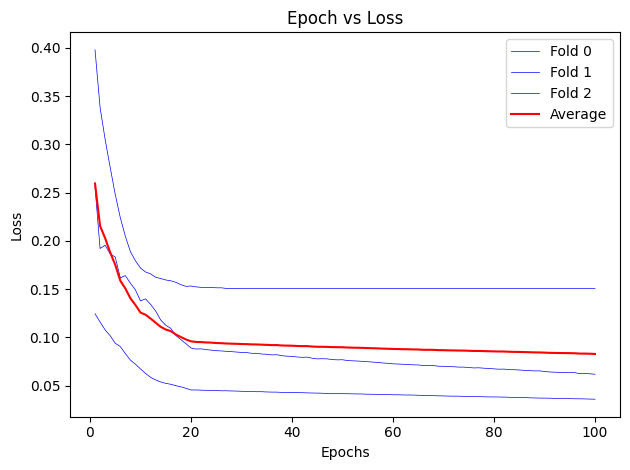

In [ ]:
history = append_history(history)
avg_val_loss_with_time_slot = np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)

for i in range(n_splits):
    loss = history[i].history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, label=f'Fold {i}', color='blue', linewidth=0.5)

plt.plot(epochs, avg_val_loss_with_time_slot, label='Average', color='red')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for i in range(n_splits):
  model_name = model_name_original + f'_fold_{i}'
  model_dictionary[model_name] = history[i].history['val_loss']

### Conclusion

In [ ]:
model_dictionary.keys()

dict_keys(['model_each_sensor_scaled_separately_fold_0', 'model_each_sensor_scaled_separately_fold_1', 'model_each_sensor_scaled_separately_fold_2', 'model_each_sensor_scaled_together_fold_0', 'model_each_sensor_scaled_together_fold_1', 'model_each_sensor_scaled_together_fold_2', 'model_with_time_slot_fold_0', 'model_with_time_slot_fold_1', 'model_with_time_slot_fold_2'])

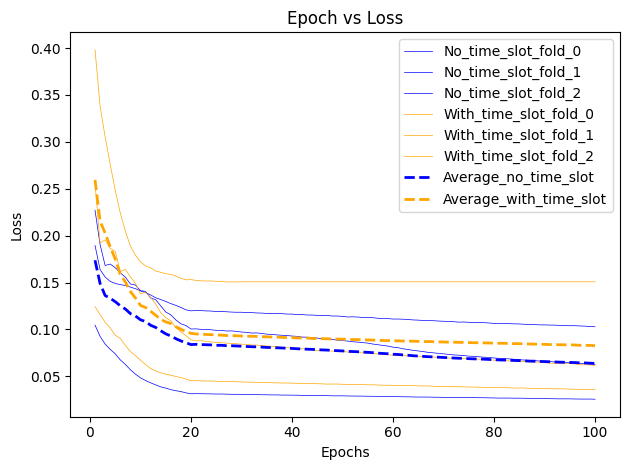

In [ ]:
for model_key in model_dictionary.keys():
    i = model_key[-1]
    loss = model_dictionary[model_key]
    epochs = range(1, len(loss) + 1)
    if 'separately' in model_key:
      plt.plot(epochs, loss, label=f'No_time_slot_fold_{i}', color='blue', linewidth=0.5)
    elif 'time_slot' in model_key:
      plt.plot(epochs, loss, label=f'With_time_slot_fold_{i}', color='orange', linewidth=0.5)

plt.plot(epochs, avg_val_loss_separate, label='Average_no_time_slot', color='blue', linewidth=2, linestyle='dashed')
plt.plot(epochs, avg_val_loss_with_time_slot, label='Average_with_time_slot', color='orange', linewidth=2, linestyle='dashed')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.ylim(0, 0.02)
plt.tight_layout()
plt.show()

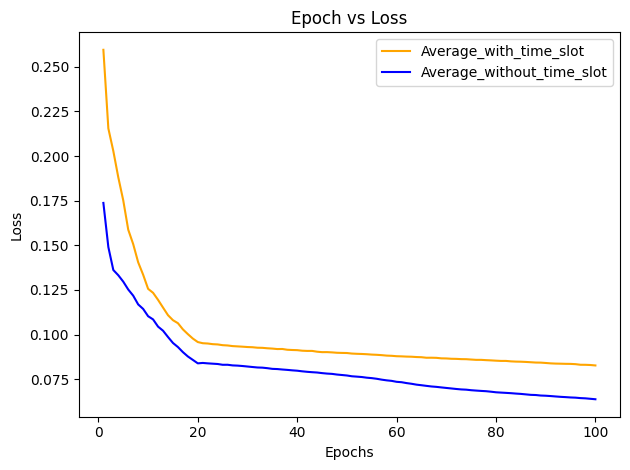

In [ ]:
epochs = range(1, len(loss) + 1)
plt.plot(epochs, avg_val_loss_with_time_slot, label='Average_with_time_slot', color='orange')
plt.plot(epochs, avg_val_loss_separate, label='Average_without_time_slot', color='blue')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Again, we do not see a significant difference. The time slots (morning, afternoon, evening, night) do not give much more to the model. Therefore it suggests that there is not a significant correlation. We can check ourselves if there is some kind of correlation with some different plots.

In [ ]:
gas = train_scaled_separate[0][:, :, 0].reshape(-1)
time_slot = train_scaled_separate[0][:, :, 4].reshape(-1)

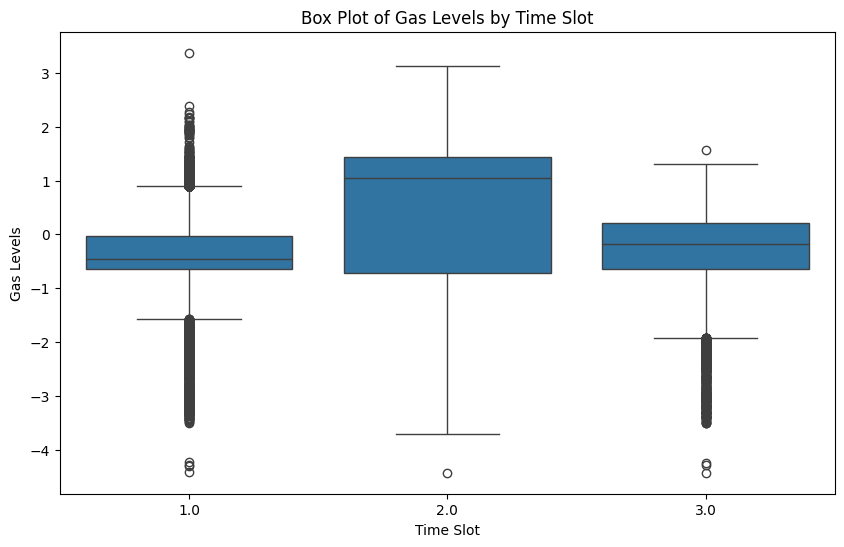

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=time_slot, y=gas)
plt.title('Box Plot of Gas Levels by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Gas Levels')
plt.show()

There is no obvious correlation between the time slot and the gas, therefore it is likely for this reason the model does not extract a relationship between them.

# Dividing data by time_slot

In [ ]:
file_name = 'E05A1B0CEE60_18022024T000000_01052024T000000_Home_#6_6_25.csv'
df = pd.read_csv(f'/content/drive/MyDrive/YieldX/csv_files/{file_name}')
df = standardize_df(df)
df['Datetime'] = df['Epoch'].apply(epoch_to_date)
df = df.sort_values(by=['Sensor', 'Step', 'Epoch'])
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = clean_df_with_time_slot(df)
assert df.isna().any().any() == False

In [ ]:
dataframes, input_all = {}, {}
selected_date = '2024-04-17'
days_before = 23
window_size = 23

for i in range(4):
  df_i = df[df['Time_Slot'] == i]
  df_i = df_i.drop('Time_Slot', axis=1)
  window_data = get_window_set(df_i, selected_date, days_before, window_size)
  input_all[i] = get_input_set_df(window_data)

100%|██████████| 94289/94289 [00:10<00:00, 8996.92it/s]


In [ ]:
train_scaled, val_scaled = {}, {}
for i in range(4):
  train, val = train_and_val_sets(input_all[i], 1)
  train_scaled[i], val_scaled[i] = scale_data_together(train, val, 1)

Fold 0:
train_all_scaled_all_sensors.shape: (229, 80, 4)
val_all_scaled_all_sensors.shape: (66, 80, 4)


Fold 0:
train_all_scaled_all_sensors.shape: (132, 80, 4)
val_all_scaled_all_sensors.shape: (66, 80, 4)


Fold 0:
train_all_scaled_all_sensors.shape: (216, 80, 4)
val_all_scaled_all_sensors.shape: (131, 80, 4)


Fold 0:
train_all_scaled_all_sensors.shape: (231, 80, 4)
val_all_scaled_all_sensors.shape: (131, 80, 4)




In [ ]:
history = {}
model_name_original = 'model_with_time_slot'
avg_val_loss_per_time_slot = {}

for i in range(4):
    print(f'##### Data of Time_Slot {i} #####')
    model_name_original = f'model_time_slot_{i}'
    autoencoder = build_model(model_name=model_name_original)
    history[i] = autoencoder.fit(train_scaled[i][0], train_scaled[i][0],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_scaled[i][0], val_scaled[i][0]),
                              callbacks=[LR, early_stopping])
    model_dictionary[model_name_original] = history[i].history['val_loss']
    # avg_val_loss_per_time_slot[i] = np.mean([history[i].history['val_loss'] for i in range(4)], axis=0)
    print(f'##########\n')
    del autoencoder

# avg_val_loss_per_time_slot[i] = np.mean([history[i].history['val_loss'] for i in range(4)], axis=0)

##### Data of Time_Slot 0 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
8/8 [==============================] - 2s 62ms/step - loss: 0.9055 - val_loss: 0.7834 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 0.7081 - val_loss: 0.7524 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.6757 - val_loss: 0.7190 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 0.6410 - val_loss: 0.6832 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.6049 - val_loss: 0.6462 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/

In [ ]:
model_dictionary.keys()

dict_keys(['model_each_sensor_scaled_separately_fold_0', 'model_each_sensor_scaled_separately_fold_1', 'model_each_sensor_scaled_separately_fold_2', 'model_each_sensor_scaled_together_fold_0', 'model_each_sensor_scaled_together_fold_1', 'model_each_sensor_scaled_together_fold_2', 'model_with_time_slot_fold_0', 'model_with_time_slot_fold_1', 'model_with_time_slot_fold_2', 'model_time_slot_0', 'model_time_slot_1', 'model_time_slot_2', 'model_time_slot_3'])

## Conclusion

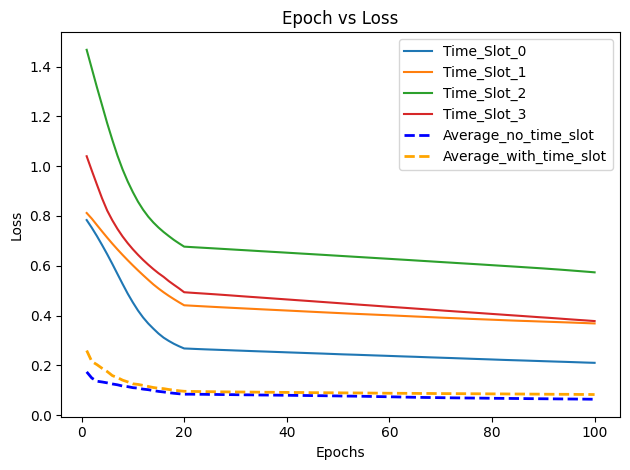

In [ ]:
for model_key in model_dictionary.keys():
    i = model_key[-1]
    loss = model_dictionary[model_key]
    epochs = range(1, len(loss) + 1)
    if 'model_time_slot' in model_key:
      plt.plot(epochs, loss, label=f'Time_Slot_{i}')

plt.plot(epochs, avg_val_loss_separate, label='Average_no_time_slot', color='blue', linewidth=2, linestyle='dashed')
plt.plot(epochs, avg_val_loss_with_time_slot, label='Average_with_time_slot', color='orange', linewidth=2, linestyle='dashed')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.ylim(0, 0.02)
plt.tight_layout()
plt.show()

It is difficult to really compare preformance since the previous models had far more data to train on. Since we are dividing the data by the time slot and there are 4 time slots, each model only gets 25% of the amount of data to train on. No matter the model architecture, this would lead to poorer preformance since it just doesn't have enough data to train on. Therefore, dividing the model into multiple dataframes based on the time_slot is not a good approach since it drastically reduces the amount of training data available.  

# Adding more complex features

### Functions

In [ ]:
# def scale_data_together_new_features(train, val, n_splits):
#   train_scaled_reshaped, val_scaled_reshaped = {}, {}

#   for i in range(n_splits):
#       scaler = StandardScaler()
#       train_scaled = scaler.fit_transform(train[i])
#       val_scaled = scaler.transform(val[i])

#       train_scaled_reshaped[i] = train_scaled.reshape(-1, 80, 6)
#       val_scaled_reshaped[i] = val_scaled.reshape(-1, 80, 6)

#       print(f'Fold {i}:')
#       print(f'train_all_scaled_all_sensors.shape:', train_scaled_reshaped[i].shape)
#       print(f'val_all_scaled_all_sensors.shape:', val_scaled_reshaped[i].shape)
#       print('\n')
#   return train_scaled_reshaped, val_scaled_reshaped

def build_model_new_features(model_name):
    input_shape = (80, 6)
    hidden1_dim = 64
    hidden2_dim = 32

    encoder_input = tf.keras.Input(shape=input_shape)
    x = layers.Conv1D(hidden1_dim, kernel_size=3, activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)

    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoder_output = layers.Conv1D(4, kernel_size=3, activation='linear', padding='same')(x)


    autoencoder = models.Model(encoder_input, decoder_output)

    autoencoder.compile(optimizer='adam', loss=custom_loss)
    return autoencoder

## Running code

In [ ]:
file_name = 'E05A1B0CEE60_18022024T000000_01052024T000000_Home_#6_6_25.csv'
df = pd.read_csv(f'/content/drive/MyDrive/YieldX/csv_files/{file_name}')
df = standardize_df(df)
df['Datetime'] = df['Epoch'].apply(epoch_to_date)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(by=['Sensor', 'Step', 'Epoch'])
df = clean_df(df)

In [ ]:
selected_date = '2024-04-17'
days_before = 23
window_size = 23

window_data = get_window_set(df, selected_date, days_before, window_size)
input_all = get_input_set_df(window_data)
print(f'input_all.shape: {input_all.shape}')


100%|██████████| 302623/302623 [00:32<00:00, 9299.27it/s] 


input_all.shape: (301440, 7)


In [ ]:
input_all['Gas*Temp'] = input_all['Gas']*input_all['Temp']
input_all['Gas*Humid'] = input_all['Gas']*input_all['Humid']

In [ ]:
input_all.head()

,Gas,Temp,Humid,Pressure,Slot,Session,Sensor_Step,Gas*Temp,Gas*Humid
0,1.271418e+05,22.370777,55.290024,1007.518188,112.0,0.0,0,2.844261e+06,7.029673e+06
1,1.737802e+06,25.051037,55.697094,1007.514343,112.0,0.0,1,4.353375e+07,9.679054e+07
2,1.971126e+06,25.356640,54.695202,1007.489929,112.0,0.0,2,4.998114e+07,1.078111e+08
3,2.652850e+06,25.737396,51.734509,1007.526062,112.0,0.0,3,6.827744e+07,1.372439e+08
4,2.708278e+05,26.316046,51.526276,1007.539124,112.0,0.0,4,7.127117e+06,1.395475e+07


In [ ]:
train, val = train_and_val_sets(input_all, 3)
train_scaled_separate, val_scaled_separate = scale_data_separate_sensors(train, val, 3)

Fold 0:
train_scaled_separately.shape: (972, 80, 6)
val_scaled_separately.shape: (262, 80, 6)


Fold 1:
train_scaled_separately.shape: (979, 80, 6)
val_scaled_separately.shape: (261, 80, 6)


Fold 2:
train_scaled_separately.shape: (969, 80, 6)
val_scaled_separately.shape: (260, 80, 6)




In [ ]:
history = {}
model_name_original = 'model_new_features'
for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model_new_features(model_name=model_name_original)
    history[i] = autoencoder.fit(train_scaled_separate[i], train_scaled_separate[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_scaled_separate[i], val_scaled_separate[i]),
                              callbacks=[LR, early_stopping])
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.2040 - val_loss: 0.1335 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0392 - val_loss: 0.0962 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0350 - val_loss: 0.0942 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0337 - val_loss: 0.0887 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0326 - val_loss: 0.0840 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

## Conclusion

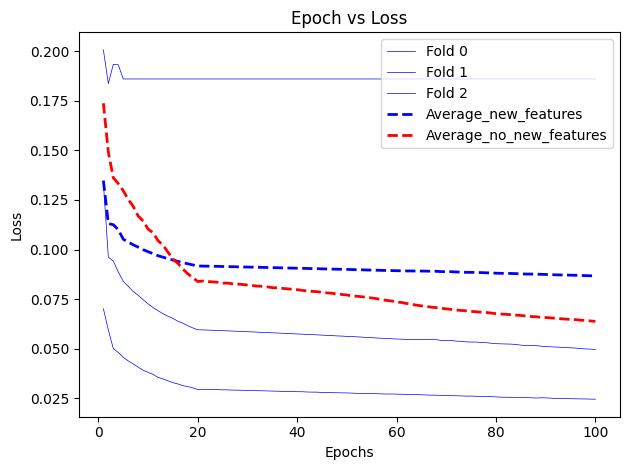

In [ ]:
history = append_history(history)
avg_val_loss_new_features = np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)

for i in range(n_splits):
    loss = history[i].history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, label=f'Fold {i}', color='blue', linewidth=0.5)

plt.plot(epochs, avg_val_loss_new_features, label='Average_new_features', color='blue', linewidth=2, linestyle='dashed')
plt.plot(epochs, avg_val_loss_separate, label='Average_no_new_features', color='red', linewidth=2, linestyle='dashed')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

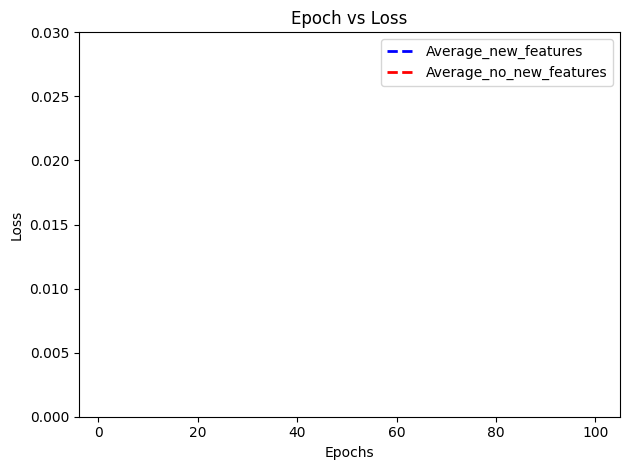

In [ ]:
plt.plot(epochs, avg_val_loss_new_features, label='Average_new_features', color='blue', linewidth=2, linestyle='dashed')
plt.plot(epochs, avg_val_loss_separate, label='Average_no_new_features', color='red', linewidth=2, linestyle='dashed')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

These additional features do appear to help the model improve. Therefore moving forward we will utilize these additional 2 features.

# Removing Pressure feature

As seen in the EDA, pressure does not follow a trend over time, nor does it appear to have a relationship with the Resistance. We will remove it as a feature and see if the model performs better.

In [ ]:
input_all = input_all.drop('Pressure', axis=1)

In [ ]:
# def scale_data_together_drop_pressure(train, val, n_splits):
#   train_scaled_reshaped, val_scaled_reshaped = {}, {}

#   for i in range(n_splits):
#       scaler = StandardScaler()
#       train_scaled = scaler.fit_transform(train[i])
#       val_scaled = scaler.transform(val[i])

#       train_scaled_reshaped[i] = train_scaled.reshape(-1, 80, 5)
#       val_scaled_reshaped[i] = val_scaled.reshape(-1, 80, 5)

#       print(f'Fold {i}:')
#       print(f'train_all_scaled_all_sensors.shape:', train_scaled_reshaped[i].shape)
#       print(f'val_all_scaled_all_sensors.shape:', val_scaled_reshaped[i].shape)
#       print('\n')
#   return train_scaled_reshaped, val_scaled_reshaped

def build_model_drop_pressure(model_name):
    input_shape = (80, 5)
    hidden1_dim = 64
    hidden2_dim = 32

    encoder_input = tf.keras.Input(shape=input_shape)
    x = layers.Conv1D(hidden1_dim, kernel_size=3, activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)

    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(hidden2_dim, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoder_output = layers.Conv1D(4, kernel_size=3, activation='linear', padding='same')(x)


    autoencoder = models.Model(encoder_input, decoder_output)

    autoencoder.compile(optimizer='adam', loss=custom_loss)
    return autoencoder

In [ ]:
train, val = train_and_val_sets(input_all, 3)
train_scaled_separate, val_scaled_separate = scale_data_separate_sensors(train, val, 3)

Fold 0:
train_scaled_separately.shape: (972, 80, 5)
val_scaled_separately.shape: (262, 80, 5)


Fold 1:
train_scaled_separately.shape: (979, 80, 5)
val_scaled_separately.shape: (261, 80, 5)


Fold 2:
train_scaled_separately.shape: (969, 80, 5)
val_scaled_separately.shape: (260, 80, 5)




In [ ]:
history = {}
model_name_original = 'model_drop_pressure'
for i in range(n_splits):
    print(f'##### Fold {i + 1} / {n_splits} #####')
    autoencoder = build_model_drop_pressure(model_name=model_name_original)
    history[i] = autoencoder.fit(train_scaled_separate[i], train_scaled_separate[i],
                              epochs=100,
                              batch_size=32,
                              validation_data=(val_scaled_separate[i], val_scaled_separate[i]),
                              callbacks=[LR, early_stopping])
    print(f'##########\n')
    del autoencoder

##### Fold 1 / 3 #####

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
31/31 [==============================] - 9s 60ms/step - loss: 0.1678 - val_loss: 0.0757 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
31/31 [==============================] - 1s 32ms/step - loss: 0.0334 - val_loss: 0.0755 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
31/31 [==============================] - 1s 29ms/step - loss: 0.0316 - val_loss: 0.0745 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0308 - val_loss: 0.0735 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
31/31 [==============================] - 1s 43ms/step - loss: 0.0301 - val_loss: 0.0719 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6

### Conclusion

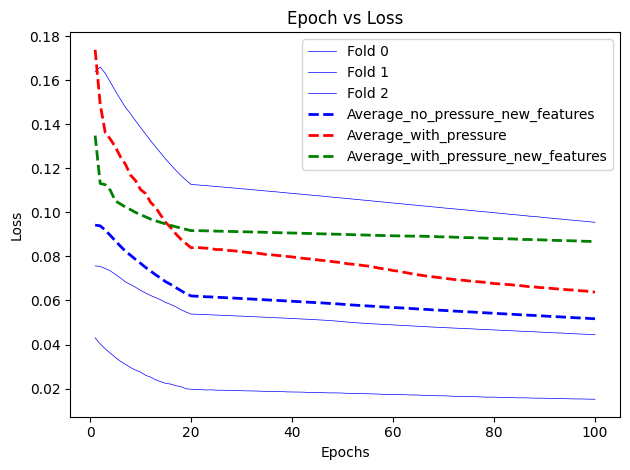

In [ ]:
history = append_history(history)
avg_val_loss_drop_pressure = np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)

for i in range(n_splits):
    loss = history[i].history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, label=f'Fold {i}', color='blue', linewidth=0.5)

plt.plot(epochs, avg_val_loss_drop_pressure, label='Average_no_pressure_new_features', color='blue', linewidth=2, linestyle='dashed')
plt.plot(epochs, avg_val_loss_separate, label='Average_with_pressure', color='red', linewidth=2, linestyle='dashed')
plt.plot(epochs, avg_val_loss_new_features, label='Average_with_pressure_new_features', color='green', linewidth=2, linestyle='dashed')

plt.title(f'Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

From this plot we can see that the Pressure feature seems to confuse the model, as the model trained on data without pressure performs better than with data containing pressure measurements. **Therefore, moving forward we will exclude Pressure from our data**

# Conclusions

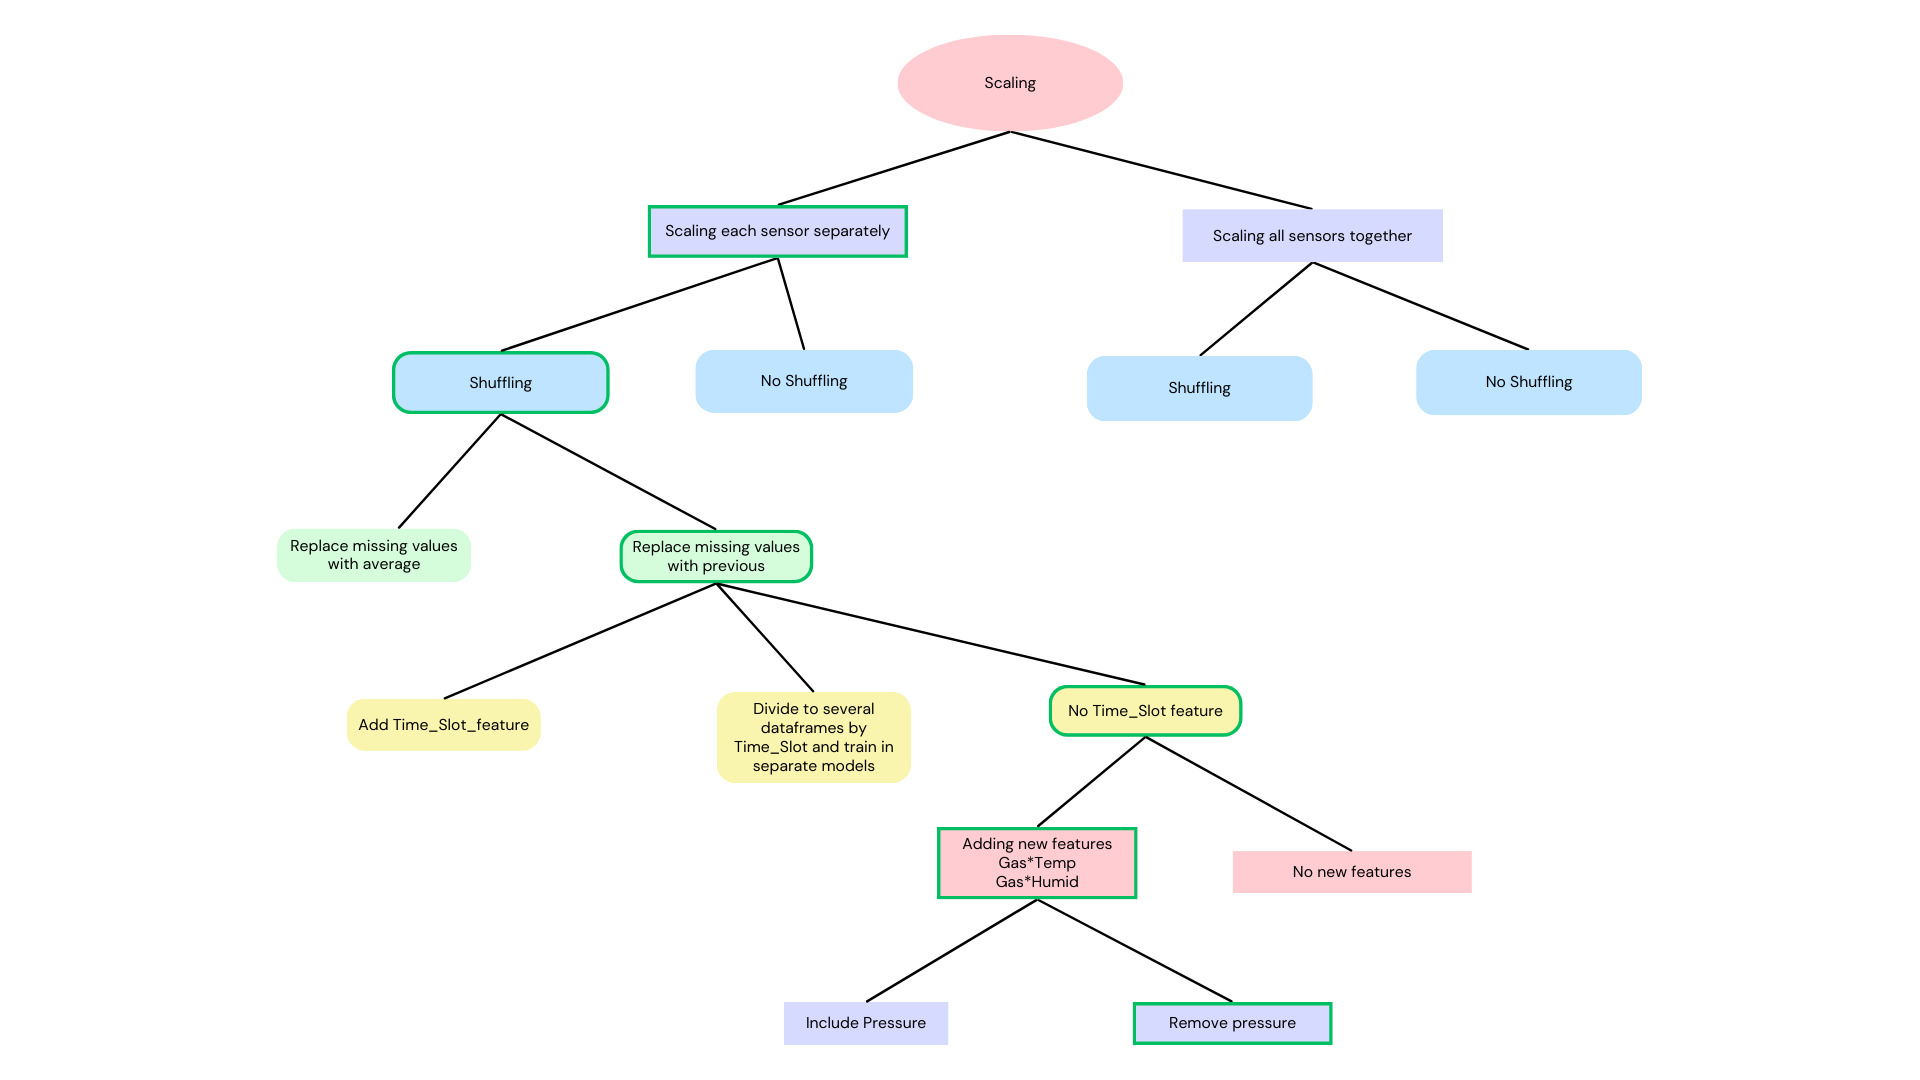

In [ ]:
from IPython.display import Image, display
img_path = '/content/drive/MyDrive/YieldX/preprocessing_workflow.png'
display(Image(filename=img_path))